## Przedmiot: Przetwarzanie i analiza danych w języku Python

### Temat: Klasyfikacja klientów na podstawie danych z kart kredytowych - porównanie różnych algorytmów

### Wykonanie: Mateusz Lepa (277971), Bartosz Ryżak (277983)

# Wstęp

W projekcie podjęto się próby klasteryzacji klientów na podstawie danych z ich kart kredytowych
Klasteryzacja jest metodą klasyfikacji bez nadzoru (z angielskiego - unsupervised learning).

Jest to metoda wykorzystywana w Machine Learningu, dokonująca grupowania elementów we względnie jednorodne klasy. 
Podstawą takiego grupowania w większości algorytmów ML jest zbieżność pomiędzy elementami, najczęściej wyrażone przy pomocy jakiejś funkcji podobieństwa.

W projekcie wykorzystano dwa algorytmy ML do owej klasteryzacji k-means oraz algorytm Ward'a.
W końcowej fazie projektu przedstawiono wnioski oraz podsumowanie.

zródło danych: https://www.kaggle.com/arjunbhasin2013/ccdata/downloads/ccdata.zip/1




In [17]:
#Wczytanie bibliotek oraz modułów 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import ward, dendrogram, linkage

In [18]:
#import zbioru danych 
dane = pd.read_csv('CC GENERAL.csv')

In [19]:
#pogląd na podstawowe statystyki opisowe
dane.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


## Czyszczenie danych

In [20]:
#Sprawdzanie czy występują wartości NA
dane.isnull().sum()
#Na podstawie artykułu https://machinelearningmastery.com/handle-missing-data-python/ postanowiono wartości NA 
#zamienić na średnią występująca w danej kolumnie 

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [21]:
# Zmiana wartości NA w kolumnie 'CREDIT_LIMIT' na średnią tej kolumny
cl_zm = dane['CREDIT_LIMIT'].mean()
dane['CREDIT_LIMIT'].fillna(cl_zm, inplace = True)
dane.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          0
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [22]:
# Zmiana wartości NA w kolumnie 'MINIMUM_PAYMENTS' na średnią tej kolumny
mp_zm = dane['MINIMUM_PAYMENTS'].mean()
dane['MINIMUM_PAYMENTS'].fillna(mp_zm, inplace = True)
dane.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [23]:
#Wszystkie wartości NA zostały usunięte z naszego datasetu.
#Również kolumna 'CUST_ID' zostanie usunięta ponieważ nie wnosi ona żadnej merytorycznej wartości.
dane.drop(['CUST_ID'], axis = 1, inplace = True )

In [24]:
dane.dtypes

BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object

In [25]:
dane.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


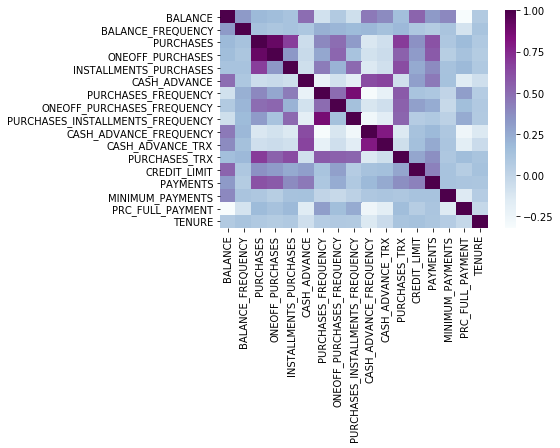

In [26]:
#Wykres koralacji
sns.heatmap(dane.corr(),
            cmap="BuPu")

C:\Users\Mateusz\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Mateusz\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


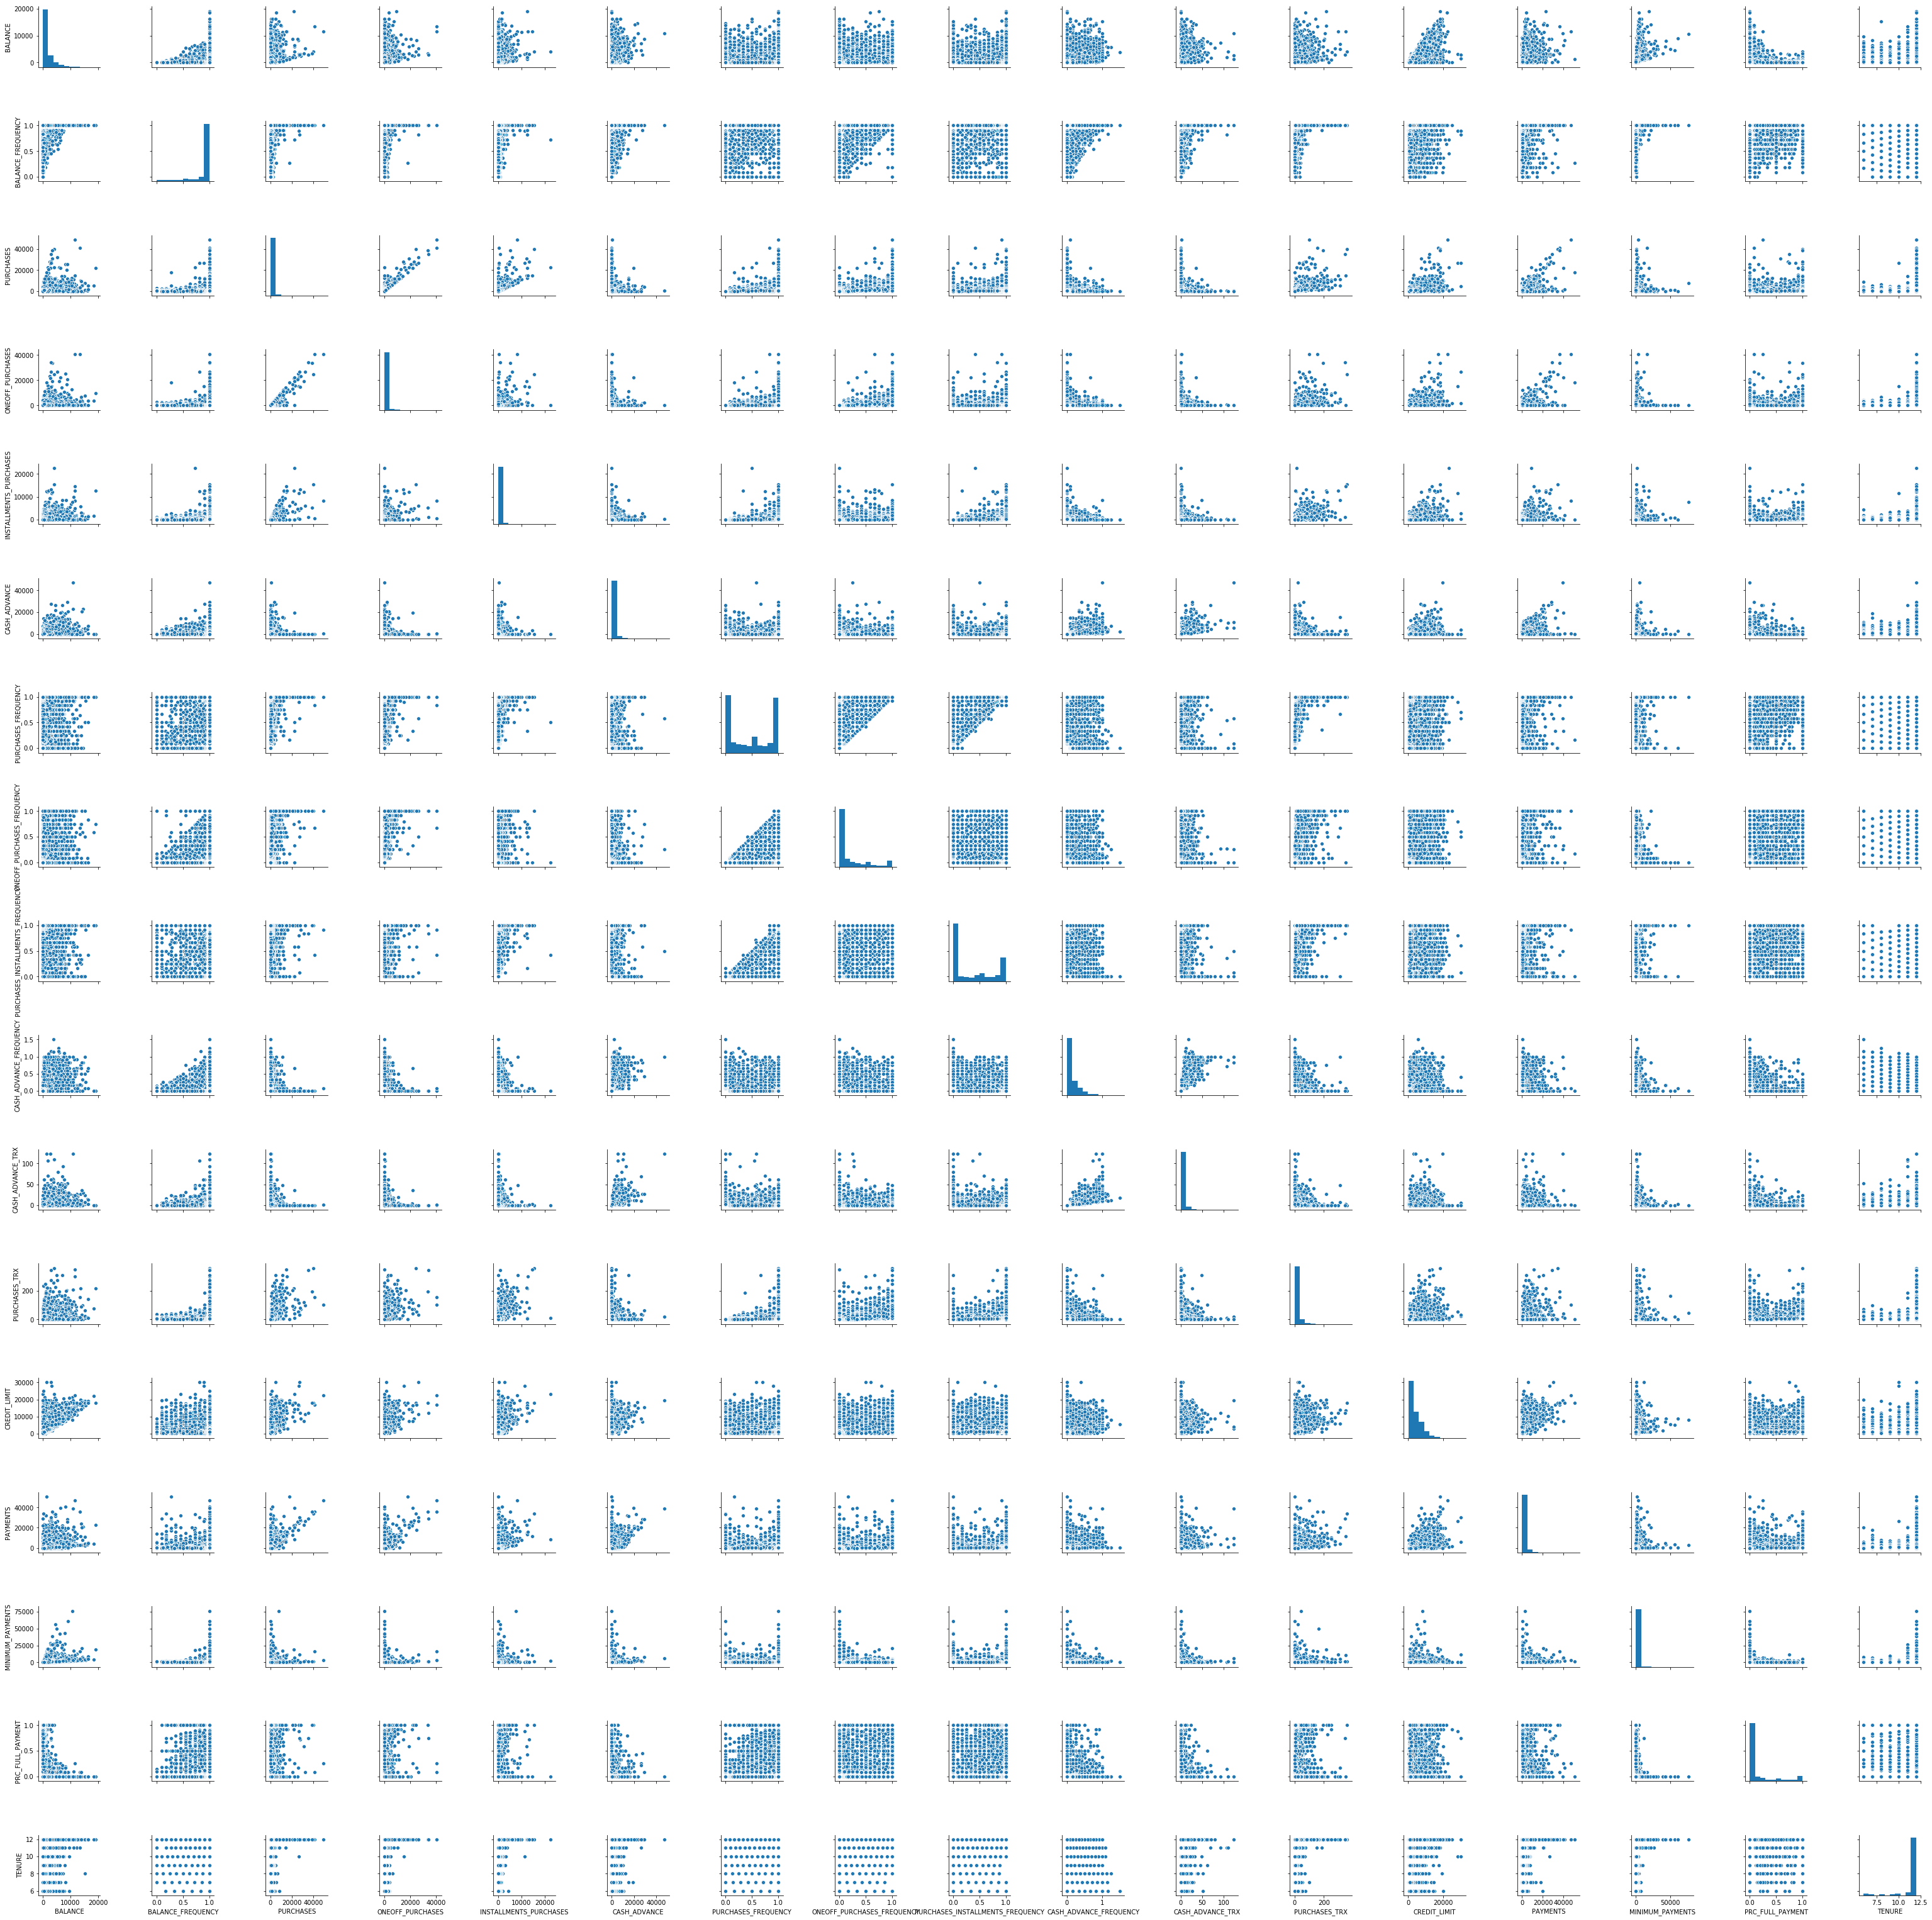

In [11]:
# wykres rozproszenia pomiędzy zmiennymi
sns.pairplot(dane)

In [27]:
#aby móc wyciągać wiarygonde wnioski na podstawie danych i przyszłych obliczeń, dataset został poddany standaryzacji
#wniosek na podstawie : https://blog.socialcops.com/academy/resources/data-standardization/ oraz https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

X = dane.values
standaryzacja= StandardScaler()
X = standaryzacja.fit_transform(X)
print(X)

#Po usunięciu wartości NA oraz standaryzacji. Zbiór danych jest gotowy do przetestowania na algorytmach ML.

[[-0.73198937 -0.24943448 -0.42489974 ... -0.31096755 -0.52555097
   0.36067954]
 [ 0.78696085  0.13432467 -0.46955188 ...  0.08931021  0.2342269
   0.36067954]
 [ 0.44713513  0.51808382 -0.10766823 ... -0.10166318 -0.52555097
   0.36067954]
 ...
 [-0.7403981  -0.18547673 -0.40196519 ... -0.33546549  0.32919999
  -4.12276757]
 [-0.74517423 -0.18547673 -0.46955188 ... -0.34690648  0.32919999
  -4.12276757]
 [-0.57257511 -0.88903307  0.04214581 ... -0.33294642 -0.52555097
  -4.12276757]]


# K - means

#### Opis algorytmu
* Utworzenie k punktów (często losowo) dla początkowych centroidów. 
* Obliczenie średnich odległości poszczególnych punktów i przypisanie im najbliższego centroidu.
* Wyznaczenie środka nowych współżędnych centroidu za pomocą średniej arytmetycznej współrzędnych wszystkich punktów mających jego grupę 
* Powtarzenie kroków 2. i 3. aż do uzyskania optymalnego rozwiązania

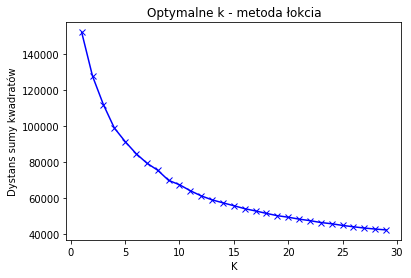

In [28]:
# wybór ilości clustrów - za pomocą metody łokcia na podstawie:
# https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set

Sum_of_squared_distances = []
K = range(1,30)

for i in K:
    kmeans= KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(X)
    Sum_of_squared_distances.append(kmeans.inertia_)


plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('K')
plt.ylabel('Dystans sumy kwadratów')
plt.title('Optymalne k - metoda łokcia')
plt.show()

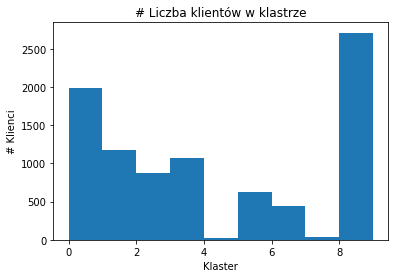

In [29]:
#na podstawie powyższego wykresu postanowiono wybrać k=9

n_clusters = 9
clustering = KMeans(n_clusters=n_clusters,
                    random_state=0
                   )

cluster_labels = clustering.fit_predict(X)

plt.hist(cluster_labels, bins=range(n_clusters+1))
plt.title('# Liczba klientów w klastrze')
plt.xlabel('Klaster')
plt.ylabel('# Klienci')
plt.show()

In [30]:
centroids = kmeans.cluster_centers_
print(centroids)

[[ 4.99917810e-01  4.94982528e-01  1.20924784e+00  1.16714718e+00
   7.14431127e-01 -2.94053765e-01  1.18336247e+00  2.04383465e+00
   1.07888871e+00 -3.80156701e-01 -3.11216911e-01  1.72838631e+00
   8.52506561e-01  4.82657964e-01  1.50310409e-02 -3.30130778e-01
   3.23809091e-01]
 [-3.96470151e-02  3.88997159e-01 -4.35766105e-01 -3.19397858e-01
  -4.43648855e-01  4.25251758e-02 -1.10562202e+00 -5.66472223e-01
  -8.87090198e-01  4.96612135e-01  1.52883998e-01 -5.58533036e-01
  -5.14470770e-01 -2.55737949e-01 -1.09590158e-01 -4.46439092e-01
   2.71804438e-01]
 [ 2.61320052e+00  4.29743529e-01 -2.97803274e-01 -2.26833383e-01
  -2.87590489e-01  3.05107622e+00 -6.41590282e-01 -3.75850561e-01
  -5.35061304e-01  1.94331408e+00  1.66457008e+00 -3.85818968e-01
   1.65775403e+00  9.64926658e-01  6.34422541e-01 -4.55677720e-01
  -1.46628023e-02]
 [ 7.40421846e-01  4.59938497e-01 -1.94224138e-01 -2.70505140e-01
   3.72891134e-02 -6.66111950e-02 -1.59281245e-01 -5.41683053e-01
   6.93230407e-02 -

# Ward Alogrithm

#### wybór algorytmu na podstawie:
https://www.statisticshowto.datasciencecentral.com/wards-method/
https://towardsdatascience.com/understanding-the-concept-of-hierarchical-clustering-technique-c6e8243758ec

#### opis algorytmu

Można zidentyfikować dwa różne typy metod hierarchicznych: aglomeracyjne (które łączą punkty w coraz większe grupy) i rozdzielające (które dzielą grupy).

* Gdy powiększamy jedno ze skupień Ck, wariancja wewnątrzgrupowa (liczona przez kwadraty odchyleń od średnich w zbiorach Ck) rośnie.
* Metoda polega na takim powiększaniu zbiorów Ck, która zapewnia najmniejszy przyrost tej wariancji dla danej iteracji.
* Kryterium grupowania jednostek: minimum zróżnicowania wektorów cech xj tworzących zbiór Ck (k= 1,....., K) względem wartości średnich w tych zbiorach.
* Metoda ta jest traktowana jako bardzo efektywna, chociaż zmierza do tworzenia skupień o małej wielkości → zrównoważone drzewa o wielu elemenatach

źródło: http://www.cs.put.poznan.pl/jstefanowski/aed/TPD-grupowanie2011.pdf

In [31]:
np.set_printoptions(precision=4, suppress=True)

In [32]:
odleglosc = linkage(dane, 'ward')

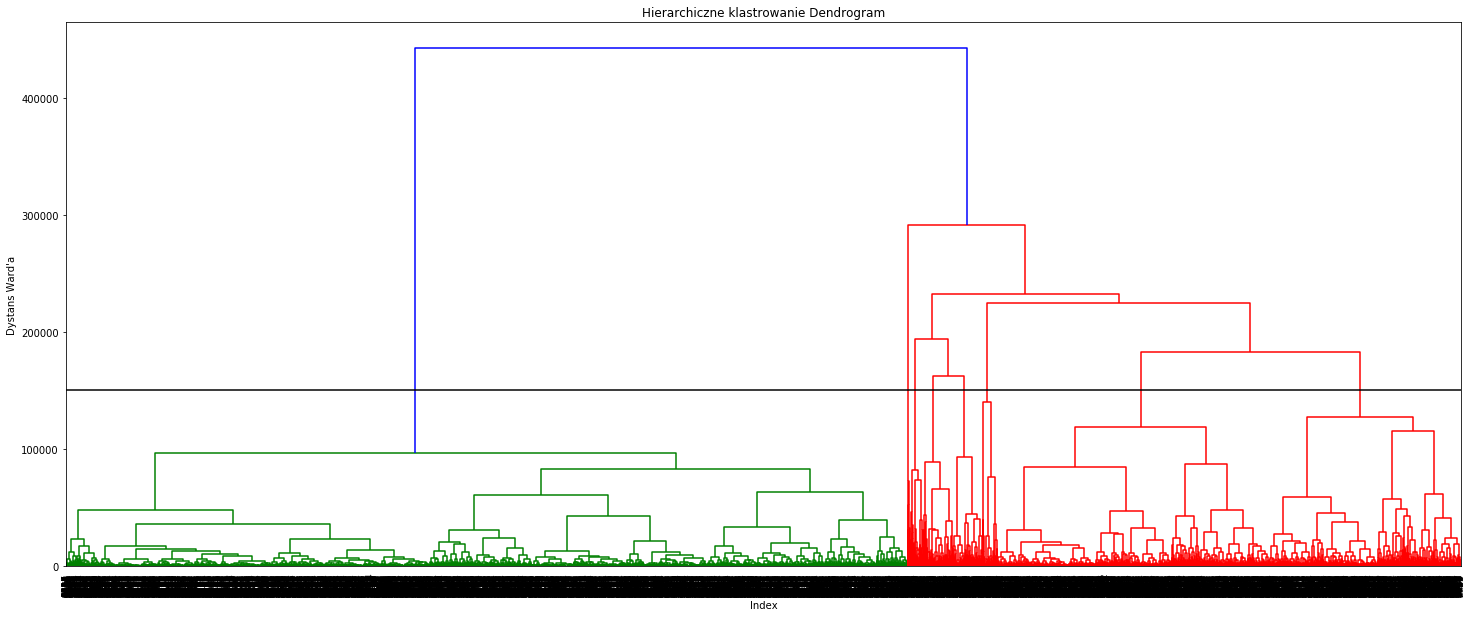

In [33]:
plt.figure(figsize=(25,10))
plt.title("Hierarchiczne klastrowanie - Dendrogram")
plt.xlabel("Index")
plt.ylabel("Dystans Ward'a")
dendrogram(odleglosc,
           leaf_rotation=90.,
           leaf_font_size=9.,);
plt.axhline(150000, c='k');

Z uwagi na podobieństwo do drzewa, takie przedstawienie jest zwanene dendrogramem. <br />
Grupy danych otrzymamy przez obcięcie dendrogramu na dowolnym poziomie. <br />
Szara pozioma linia sugeruje wyznaczenie od 6 do 8 klas. <br />
Do dalszej częśi algorytmu wybrano 6 klas

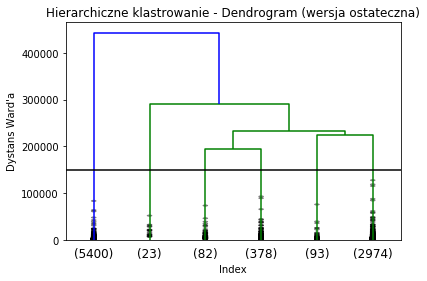

In [36]:
plt.title("Hierarchiczne klastrowanie - Dendrogram (wersja ostateczna)")
plt.xlabel("Index")
plt.ylabel("Dystans Ward'a")
dendrogram(odleglosc, truncate_mode='lastp',
           p=6, leaf_rotation=0., leaf_font_size=12.,
           show_contracted=True);
plt.axhline(150000, c='k');

# Podsumowanie


Za pomocą algorytmu k-means otrzymano 9 grup klientów, <br />
natomiast za pomocą klastrowania hierarchicznego otrzymano 6 grup klientów. <br />
Jako, że k-means oraz algorytm Ward'a to metody klasyfikacji bez nadzoru oba rozwiązania są akceptowalne i tylko od nas zależy które powinno zostać wykorzystane na "produkcji"

Przy wyborze odpowiedniego algorytmu nalezy również rozważyć plusy i minusy poszczególnych rozwiązań.

### k- means

#### Zalety:
* niska złożoność, a co za tym idzie wysoka wydajność działania
* przy dużych zbiorach i niskich ilościach grupa algorytm ten będzie zdecydowanie szybszy niż pozostałe algorytmy tej klasy
* pogrupowane zbiory są z reguły bardziej ciaśniejsze i zbite

#### Wady:

* nie pomaga w określeniu ilości grup (K)
* różne wartości początkowe prowadzą do różnych wyników

źródło: http://itcraftsman.pl/algorytm-k-srednich-uczenie-nienadzorowane/

### Ward Alogrithm

#### Zalety
* Metoda metody Warda dobrze radzi sobie również z rozdzielaniem klastrów, jeśli między klastrami występuje szum.
* Algorymt pozwala na optymalizacje rozwiązania.

#### Wady:
* Bardziej złożona niż k-means
* przy dużej ilości danych czas wykonannia algorytmu zwiększa się


źródło: https://towardsdatascience.com/understanding-the-concept-of-hierarchical-clustering-technique-c6e8243758ec